# The multislice algorithm

This is a short lesson on the theory of the multislice method. For a more complete, formal discussion including detailed theory see Advanced Computing Computing in Electron Microscopy by EJ Kirkland.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read

from abtem.waves import Waves
from abtem.potentials import Potential
from abtem.plot import plot_atoms
from abtem.utils import energy2sigma, energy2wavelength
from abtem.parametrizations import load_lobato_parameters, lobato

## Specimen potential
The electron beam interacts with the specimen through the Coulomb potential of the electrons and nuclei in the specimen. The electron charge distribution of an atom can be calculated from a first-principles electronic structure calculation, while the atomic nuclei are a point charges at the resolution of a TEM. Given a charge distribution, the potential can be obtained via Poisson's equation. 

Simulation codes include a parametrization of the atomic potentials, with a table of parameters for each element fitted to Hartree-Fock calculations. Below we show the radial depedence of the electrostatic potential of five selected elements, using the default parametrization in abTEM. This parametrization is due to Lobato et. al., it is the latest and most accurate parametrization.

In [10]:
parameters = load_lobato_parameters()
parameters

{1: array([[ 0.01374605, -1.04589803,  1.22372722, -0.81329389,  1.19007127],
        [ 3.76488543,  3.77097939,  3.77153532,  3.77684146,  3.77853072]]),
 2: array([[  26.52865888, -671.64957798,  709.74326709,  -66.11906391,
            3.41476459],
        [   6.01910439,    6.48116658,    6.53192457,    6.92618047,
            8.26883012]]),
 3: array([[ 1.66769726, -4.02814853,  2.56586084,  2.70921846,  0.33462156],
        [ 2.20188203,  2.81290612,  3.0864184 ,  9.9108022 , 15.88370415]]),
 4: array([[ 3.58165945, -3.10769082,  4.66438389, -4.27927972,  3.92093349],
        [ 2.98096095,  3.44600333, 14.42323879, 21.27854331, 21.8380965 ]]),
 5: array([[ 2.00188667, -8.79657795,  8.15643314,  4.57791364,  0.5427117 ],
        [ 3.24473522,  8.19344674,  8.74997337, 18.0347717 , 24.07752933]]),
 6: array([[ 326.06373912, -621.30494253,  657.20083889, -360.1463512 ,
            6.57337913],
        [   4.03797638,    4.13817317,    4.38995265,    4.51861056,
           22.6580872

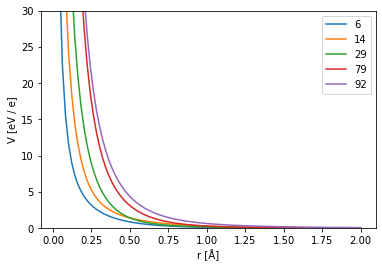

In [13]:
atomic_numbers = [6, 14, 29, 79, 92]

r = np.linspace(0,2,100)

for atomic_number in atomic_numbers:
    v = lobato(r, parameters[atomic_number])
    plt.plot(r, v, label=atomic_number)

plt.xlabel('r [Å]')
plt.ylabel('V [eV / e]')
plt.ylim([0,30])
plt.legend();

The full specimen potential, $V(r)$, is then obtained as a linear superposition of the atomic potentials

$$
    V(r) = \sum_i V_i(r-r_i) \quad ,
$$

where $V_i(r)$ is the atomic potential of the $i$'th atom. This model obviously neglects any effect due to bonding and charge transfer. However, since the nucleus and core electrons constitute most of the charge in an atom, this is often reasonable approximation, which gets progressively better as the atomic number increases. Nonetheless, due to recent improvements in microscopes, interest in going beyond this approximation have started. For example, it has been shown that simulated images based on potentials from DFT calculations can provide a better match with experimental data for light elements. This will be investigated later in this tutorial.

Below the projected potential of one layer of Strontium Titanate is shown.

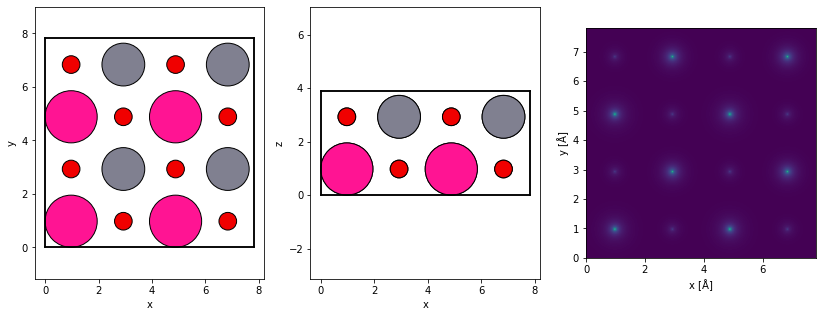

In [17]:
srtio = read('../../../../data/SrTiO.traj')
srtio *= (2,2,1)
srtio.center()
potential = Potential(srtio, num_slices=1, gpts=1024)

proj_potential = potential.get_slice(0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
plot_atoms(srtio, ax=ax1)
plot_atoms(srtio, ax=ax2, plane='xz')
ax3.imshow(proj_potential.T, extent=[0, potential.extent[0], 0, potential.extent[1]], origin='lower')
ax3.set_xlabel('x [Å]')
ax3.set_ylabel('y [Å]');

## Multislice algorithm

![title](data/multislice.png)

The energy of the incident electron waves (100 - 1000 keV) are much higher than the specimen potential, which provides only minor perturbations on the forward motion of the electrons. Hence, it is useful to write the wave function, $\psi$, of the propagating electrons as a slowly varying plane wave along the optical axis, $z$, with an amplitude modulation

$$
    \psi(\vec{r}) = \phi(\vec{r})\exp(2\pi iz/\lambda) \quad ,
$$

where $\vec{r} = (x,y,z)$ and $\lambda$ is the de Broglie wavelength of the electrons. Substituting this into the Schrödinger equation we obtain

$$
    -\frac{\hbar^2}{2m} \left[\nabla_{xy}^2 + \frac{\partial^2}{\partial z^2} + \frac{4\pi i}{\lambda}\frac{\partial}{\partial z} + \frac{2meV(\vec{r})}{\hbar^2}  \right] \phi(\vec{r}) = 0 \qquad \nabla_{xy}^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \quad .
$$

In the high energy approximation, we assume that the wavefunction varies slowly in the $z$-direction compared to the potential and that the wavelength is small, thus

$$
    \left| \frac{\partial^2 \phi}{\partial z^2} \right| \ll \left| \frac{1}{\lambda} \frac{\partial \phi}{\partial z} \right| \quad .
$$

Hence, the Schrödinger equation simplifies to a first order differential equation in $z$

$$
    \frac{\partial \phi(\vec{r})}{\partial z} = \left[\frac{i\lambda}{4\pi} \nabla_{xy}^2 + i \sigma V(\vec{r}) \right] \phi(\vec{r}) \quad ,
$$

where $\sigma=2\pi me\lambda/h^2$ is the interaction parameter. This equation is integrated numerically by slicing the potential into thin slices, such that the influence of each slice can be approximated as a simple phase shift of the wave function. The wave function is propagated between slices as a small angle outgoing wave (Fresnel diffraction). The transmission and propagation across a single slice can be written

$$
    \phi(x, y, z + \Delta z) = p(x,y,\Delta z) * [t(r) \psi(\vec{r})] + \mathcal{O}(\Delta z^2) \quad ,
$$

where $*$ represents a convolution. The transmission function, $t(r)$, for the portion of the potential between $z$ and $z+\Delta z$ is

$$
    t(\vec{r}) = \exp\left[i\sigma \int_z^{z+\Delta z} V(\vec{r}) dz'\right] \quad ,
$$

and the Fresnel propagator $p(x, y, \Delta z)$ is

$$
    p(x,y,\Delta z) = \frac{1}{i \lambda \Delta z}\exp\left[\frac{i\pi}{\lambda \Delta z}(x^2+y^2)\right] \, .
$$

The wave at the exit plane of the specimen is obtained by sequentially propagating and transmitting the wave function starting with an assumed input wave.

Convolutions can be performed efficiently by utilizing the Fast Fourier Transform (FFT). The implemented form of Eq. the single slice propagation is

$$
    \phi_{z + \Delta z}(x,y) = \mathcal{F}^{-1}\{P(k_x, k_y, \Delta z) \mathcal{F}[t(\vec{r}) \phi(\vec{r})] \} \quad ,
$$

where $P$ is the Fourier transform of the fresnel propagator. The computational cost for the FFT scales as $N \log(N)$ with the number of samples $N$.